# Queries: using the search module

<figure style="display: table; text-align:center; margin-left: auto; margin-right:auto">

[![Binder](https://mybinder.org/badge_logo.svg)](https://binder.materials-data.space/v2/gh/simphony/docs/dome4.0?filepath=docs%2Fusage%2Fsessions%2Fsearch.ipynb "Click to run this tutorial yourself!")
    
</figure>

The search module enables more advanced queries of session's contents when compared to the [methods from the session object](queries.ipynb). It is intended to offer a pythonic approach to querying the session, but still, it has significant efficiency and expresivity limitations. An additional constraint is the topology of the graph that the relationships (and annotations) between the individuals form, as the functions from the module work **traversing the graph from a given initial individual**. Therefore, whenever you require more advanced or more performant queries, use [SPARQL](sparql.ipynb).

SimPhoNy's search module is located under `simphony_osp.tools.search` and can be imported as follows.

In [1]:
from simphony_osp.tools import search

The following functions are available:

- [find](#find)
- [find_by_identifier](#find_by_identifier)
- [find_by_class](#find_by_class)
- [find_by_attribute](#find_by_attribute)
- [find_relationships](#find_relationships)

A `sparql` function is also provided by the module. However, it is not covered in this section, [but the next one](sparql.ipynb).

To see how these functions work, let's set-up an example with two cities, Freiburg and Paris.

In [2]:
from simphony_osp.namespaces import city, owl, rdfs
from simphony_osp.session import core_session

# Create a city called "Freiburg"
freiburg = city.City(name="Freiburg", coordinates=[47.997791, 7.842609])
freiburg_neighborhoods = [
    city.Neighborhood(name=name, coordinates=coordinates)
    for name, coordinates in [
        ('Altstadt', [47.99525, 7.84726]),
        ('Stühlinger', [47.99888, 7.83774]),
        ('Neuburg', [48.00021, 7.86084]),
        ('Herdern', [48.00779, 7.86268]),
        ('Brühl', [48.01684, 7.843]),
    ]
]
freiburg_citizens = {
    city.Citizen(name='Nikola', age=35,
                 iri="http://example.org/entities#Nikola"),
    city.Citizen(name='Lena', age=70,
                 iri="http://example.org/entities#Lena"),
}
freiburg[city.hasPart] |= freiburg_neighborhoods
freiburg[city.hasInhabitant] |= freiburg_citizens

# Create a city called "Paris"
paris = city.City(name="Paris", coordinates=[48.85333, 2.34885])
paris_neighborhoods = {
    city.Neighborhood(name=name, coordinates=coordinates)
    for name, coordinates in [
        ('Louvre', [48.86466, 2.33487]),
        ('Bourse', [48.86864, 2.34146]),
        ('Temple', [48.86101, 2.36037]),
        ('Hôtel-de-Ville', [48.85447, 2.35902]),
        ('Panthéon', [48.84466, 2.3471]),
    ]
}
paris_citizens = {
    city.Citizen(name='François', age=32)
}
paris[city.hasPart] |= paris_neighborhoods
paris[city.hasInhabitant] = paris_citizens

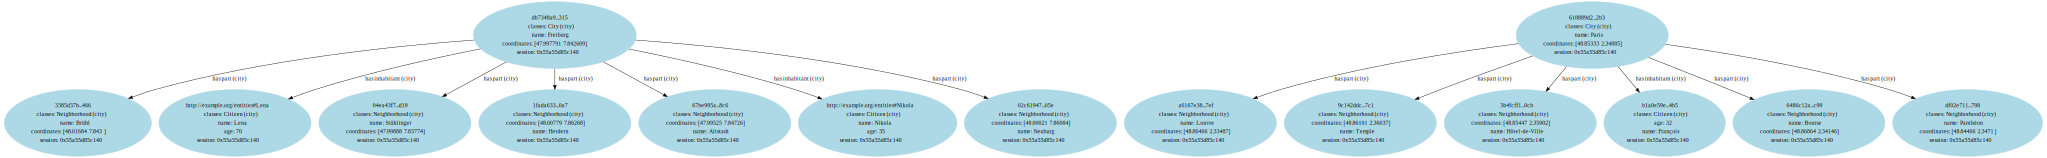

In [3]:
from simphony_osp.tools import semantic2dot  # explained in a later section

semantic2dot(freiburg, *freiburg_neighborhoods, *freiburg_citizens,
             paris, *paris_neighborhoods, *paris_citizens)

<div class="admonition important">
<div class="admonition-title" style="font-weight: bold"><div style="display: inline-block">Tip</div></div>
    
On most web browsers (including mobile ones), you can right-click the picture above and then click "open in new tab" to see the picture in its full size.
    
</div>

The most important detail to keep in mind is that the functions above do not act on a session object, but on an ontology individual object that has to be provided beforehand. They perform the search by **traversing the relationships and annotations in the graph starting from the given individual**.
        
This is the precisely the reason why a directed graph with two [weakly connected components](https://en.wikipedia.org/wiki/Connectivity_(graph_theory)) is provided as example: it illustrates that it is impossible to find individuals from one of the components if the search function is called on an individual belonging to another component. Head to the first subsection, dealing with the function [find](#find), to see this behavior in action.

## `find`

The function `find` traverses the graph starting from a given _root_ individual, following only relationships that are a subclass of the _given relationships_, and annotations that are a subclass of the _given annotations_. Along the path, it verifies a given _criterion_ on each ontology individual it finds, and then returns the matching individuals.

To clarify how it works, several calls of increasing difficulty to this function, applied to the graph constructed at the top of this page, are shown as examples.

The simplest call just needs the positional argument `root`. As no relationships nor annotations are provided, all relationships and annotations are followed. Similarly, as no criterion is provided, it is always assumed to be satisfied. 

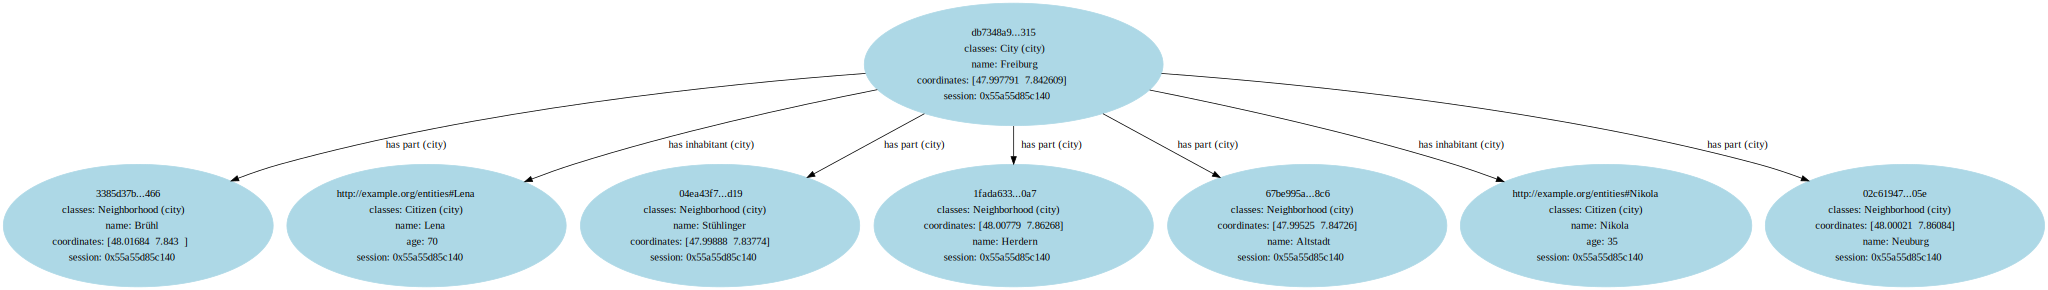

In [4]:
found = list(
    search.find(freiburg)
)

semantic2dot(*found)

As it can be seen above, when using `freiburg` as the root object, the result is the subgraph of all ontology individuals reachable from `freiburg`. None of the citizens or neighborhoods of `paris` are returned, as they cannot be reached from the `freiburg` individual.

To increase the complexity of the query, the relationships to be followed can be limited to the subclasses of various selected relationships using the `rel` keyword arugment. For example, let's restrict the search to inhabitants and workers of Freiburg (as well as Freiburg itself).

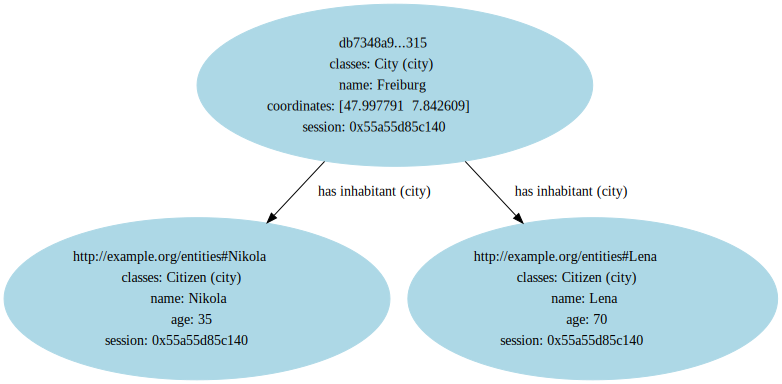

In [5]:
found = list(
    search.find(
        freiburg,
        rel=(city.hasInhabitant, city.hasWorker)  # if only one relationship has to be considered, just pass it directly (i.e. `rel=city.hasInhabitant`)
    )  
)

semantic2dot(*found)

<div class="admonition note">
<div class="admonition-title" style="font-weight: bold"><div style="display: inline-block">Note</div></div>

There is a similar keyword argument `annotation` that can be used to constrain the ontology annotations to follow. Just like for the `rel` argument, it can take as values either a single annotation or several ones. However, in addition, it also accepts boolean values. Setting it to `True` means following all annotations (the default value), while setting it to `False` means following no annotations at all.

</div>

The next complexity step is passing a function as search criterion. For example, one may want to restrict the search to persons that are more than 40 years old.

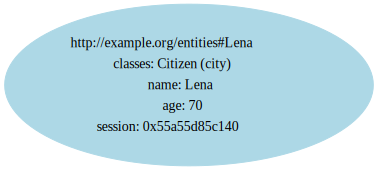

In [6]:
found = list(
    search.find(
        freiburg,
        criterion=lambda individual: individual.is_a(city.Person) and individual.age > 40,
        rel=(city.hasInhabitant, city.hasWorker)
    )  
)

semantic2dot(*found)

Note that `freiburg` itself does not satisfy the given criterion, and thus it is excluded from the results.

That is all! You have mastered the `find` function, although there are still two little details that allow to control the algorithm and the output.

Relaxing the criterion to just requiring the results to be persons and re-running the search with the keyword argument `find_all=False` causes the search to return only the first individual it finds.

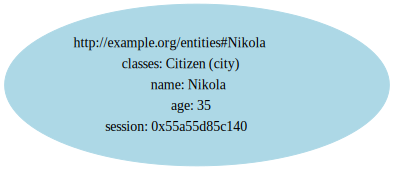

In [7]:
found = search.find(
    freiburg,
    criterion=lambda individual: individual.is_a(city.Person),
    rel=(city.hasInhabitant, city.hasWorker),
    find_all=False,
)  

semantic2dot(found)

Lastly, the maximum depth of the search can be adjusted using the `max_depth` parameter. Try setting it to `0`, it should yield no results!

In [8]:
found = list(
    search.find(
        freiburg,
        criterion=lambda individual: individual.is_a(city.Person),
        rel=(city.hasInhabitant, city.hasWorker),
        max_depth=0,
    )  
)

semantic2dot(*found)

## `find_by_identifier`

This function is constructed as a call to [find](#find), but with the criterion fixed to matching the given identifier. 

The positional arguments `root` and keyword arguments `rel` and `annotation` behave exactly like in [find](#find). An additional positional argument, `identifier` is required. The keyword arguments `criterion`, `find_all` and `max_depth` are not available, as they are fixed to: matching the given identifier, `False` (as identifiers are unique) and unlimited. 

Therefore, this function yields either `None` or a single ontology individual whose identifier matches the given one.

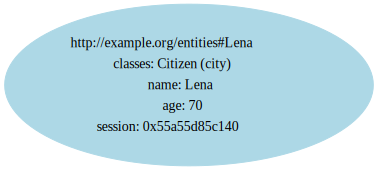

In [9]:
found = search.find_by_identifier(
    freiburg,
    "http://example.org/entities#Lena",
    rel=owl.topObjectProperty,
)  

semantic2dot(found)

## `find_by_class`

This function is also constructed as a call to [find](#find), but with the criterion fixed to the individual belonging to a specific ontology class. 

Just like before, the positional arguments `root` and keyword arguments `rel` and `annotation` behave exactly like in [find](#find). An additional positional argument, `oclass` is required. The keyword arguments `criterion`, `find_all` and `max_depth` are not available, as they are fixed to: the individual belonging to the given class, `True` (as identifiers are unique) and unlimited. 

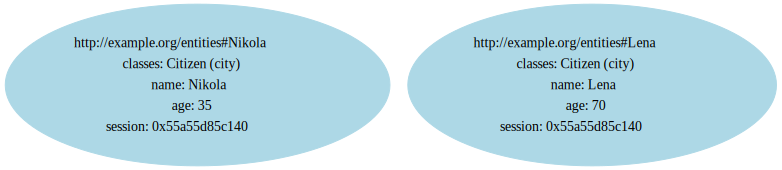

In [10]:
found = list(search.find_by_class(
    freiburg,
    city.Person,
    rel=owl.topObjectProperty,
))

semantic2dot(*found)

## `find_by_attribute`

Finds individuals that have a matching attribute value. `find_all` is set to `True` and `max_depth` to unlimited.

For example, looking for individuals that are 35 years old yields Nikola.

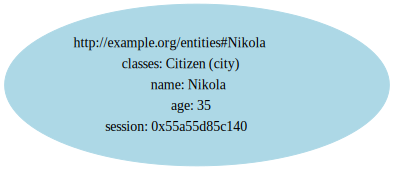

In [11]:
found = list(search.find_by_attribute(
    freiburg,
    city.age,
    35,
    rel=owl.topObjectProperty,
))

semantic2dot(*found)

## `find_relationships`

In this case, individuals that are attached to any other individual through the given relationship (the _source_ individuals of the relationship) are returned. `find_all` is set to `True` and `max_depth` to unlimited.

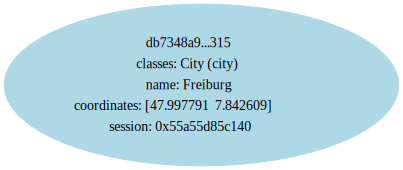

In [12]:
found = list(search.find_relationships(
    freiburg,
    city.hasInhabitant,  # the relationship used as criterion
    rel=owl.topObjectProperty,  # the usual `rel` argument, only this and sub-relationships will be traversed during the search
))

semantic2dot(*found)

Note that however, by default sub-relationships of the given relationship are not considered. This can be demonstrated using `owl.topObjectProperty` as relationship, as no results are yielded when doing so

In [13]:
found = list(search.find_relationships(
    freiburg,
    owl.topObjectProperty,  # the relationship used as criterion
    rel=owl.topObjectProperty,  # the usual `rel` argument, only this and sub-relationships will be traversed during the search
))

semantic2dot(*found)

unless the keyword argument `find_sub_relationships` is set to `True`.

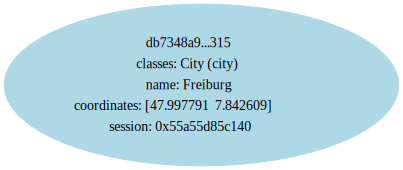

In [14]:
found = list(search.find_relationships(
    freiburg,
    owl.topObjectProperty,  # the relationship used as criterion
    find_sub_relationships=True,
    rel=owl.topObjectProperty,  # the usual `rel` argument, only this and sub-relationships will be traversed during the search
))

semantic2dot(*found)